# Hybrid Anomaly Detector (No Fixed Thresholds)

**Problem:** Our current Z-score threshold (2.5) only catches extreme spikes and misses obvious anomalies.

**Solution:** Combine 3 threshold-free methods:
1. **STL Decomposition** - Separates seasonal patterns, finds anomalies in residuals using IQR
2. **Scipy find_peaks with Prominence** - Finds peaks that stand out relative to surrounding data
3. **Local Outlier Factor (LOF)** - Density-based detection, compares to neighbors

**Final:** Ensemble voting - only flag as anomaly if 2+ methods agree


## 1. Import Libraries


In [4]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Anomaly Detection Methods
from scipy.signal import find_peaks
from scipy.stats import iqr
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

sns.set_style('whitegrid')
print("✅ Libraries imported")


✅ Libraries imported


## 2. Load Sample Map Data (Peely vs Jonesy)


In [6]:
# Load the Peely vs Jonesy map as our test case
DATA_DIR = Path('../data/raw')

# Load specific map (note: filename uses underscores)
test_map_file = DATA_DIR / 'map_8530_0110_2817.json'

with open(test_map_file, 'r') as f:
    test_data = json.load(f)

map_name = test_data['map_data'].get('name', 'Unknown')
ccu_series = test_data['stats_7d']['data']['stats']

print(f"📊 Loaded: {map_name}")
print(f"   Data points: {len(ccu_series)}")
print(f"   CCU range: {min(ccu_series)} - {max(ccu_series)}")
print(f"   Mean CCU: {np.mean(ccu_series):.1f}")
print(f"   Std CCU: {np.std(ccu_series):.1f}")


📊 Loaded: 🍌PEELY VS JONESY🦸‍♂️
   Data points: 335
   CCU range: 2 - 1234
   Mean CCU: 320.4
   Std CCU: 322.7


/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127820 (\N{BANANA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129464 (\N{SUPERHERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


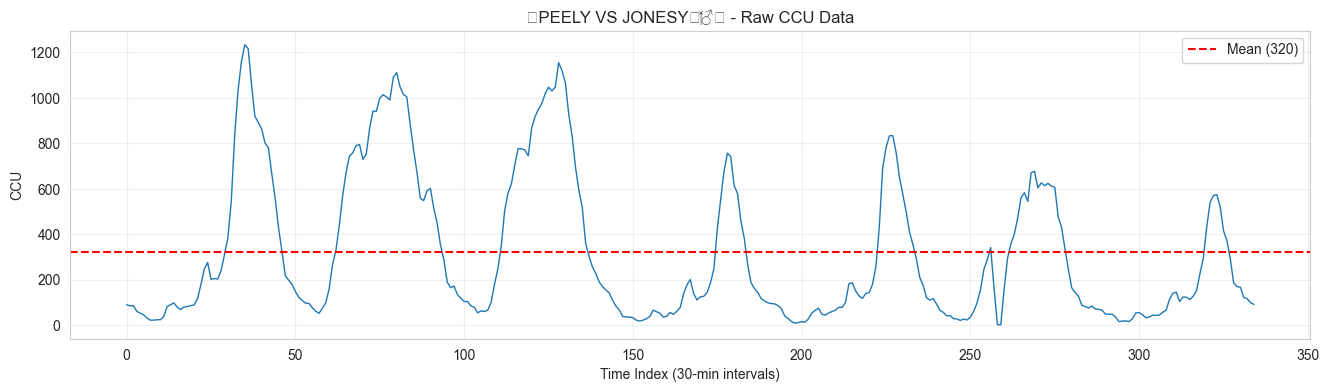


🔍 We can clearly see multiple spikes that should be detected as anomalies


In [7]:
# Quick visualization of the raw data
plt.figure(figsize=(16, 4))
plt.plot(ccu_series, linewidth=1)
plt.axhline(np.mean(ccu_series), color='red', linestyle='--', label=f'Mean ({np.mean(ccu_series):.0f})')
plt.xlabel('Time Index (30-min intervals)')
plt.ylabel('CCU')
plt.title(f'{map_name} - Raw CCU Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n🔍 We can clearly see multiple spikes that should be detected as anomalies")


## 3. Method 1: STL Decomposition + IQR

STL (Seasonal and Trend decomposition using Loess) separates:
- **Seasonal**: Daily patterns (players peak at certain hours)
- **Trend**: Overall direction
- **Residual**: What's left = anomalies!

We use IQR on residuals (no fixed threshold - adapts to data)


In [8]:
def detect_anomalies_stl(ccu_series, period=48):
    """
    Detect anomalies using STL decomposition + IQR on residuals.
    
    Args:
        ccu_series: List of CCU values
        period: Seasonal period (48 = 24 hours at 30-min intervals)
    
    Returns:
        anomaly_indices: List of indices where anomalies were detected
        residuals: The residual component from STL
    """
    arr = np.array(ccu_series, dtype=float)
    
    # Handle edge case
    if len(arr) < period * 2:
        print(f"⚠️ Not enough data for STL (need {period * 2}, have {len(arr)})")
        return [], arr, None
    
    # STL decomposition
    stl = STL(arr, period=period, robust=True)
    result = stl.fit()
    
    residuals = result.resid
    
    # Use IQR to find anomalies in residuals (no fixed threshold!)
    Q1 = np.percentile(residuals, 25)
    Q3 = np.percentile(residuals, 75)
    IQR = Q3 - Q1
    
    # Anomalies are points outside 1.5 * IQR (standard box plot rule)
    # For spikes, we only care about upper outliers
    upper_bound = Q3 + 1.5 * IQR
    
    anomaly_indices = np.where(residuals > upper_bound)[0].tolist()
    
    return anomaly_indices, residuals, result

print("✅ STL anomaly detection function defined")


✅ STL anomaly detection function defined


In [9]:
# Test STL method
stl_anomalies, residuals, stl_result = detect_anomalies_stl(ccu_series)

print(f"📊 STL Decomposition Results:")
print(f"   Anomalies found: {len(stl_anomalies)}")
print(f"   Anomaly indices: {stl_anomalies[:20]}..." if len(stl_anomalies) > 20 else f"   Anomaly indices: {stl_anomalies}")


📊 STL Decomposition Results:
   Anomalies found: 68
   Anomaly indices: [40, 61, 63, 64, 65, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 109, 111, 112]...


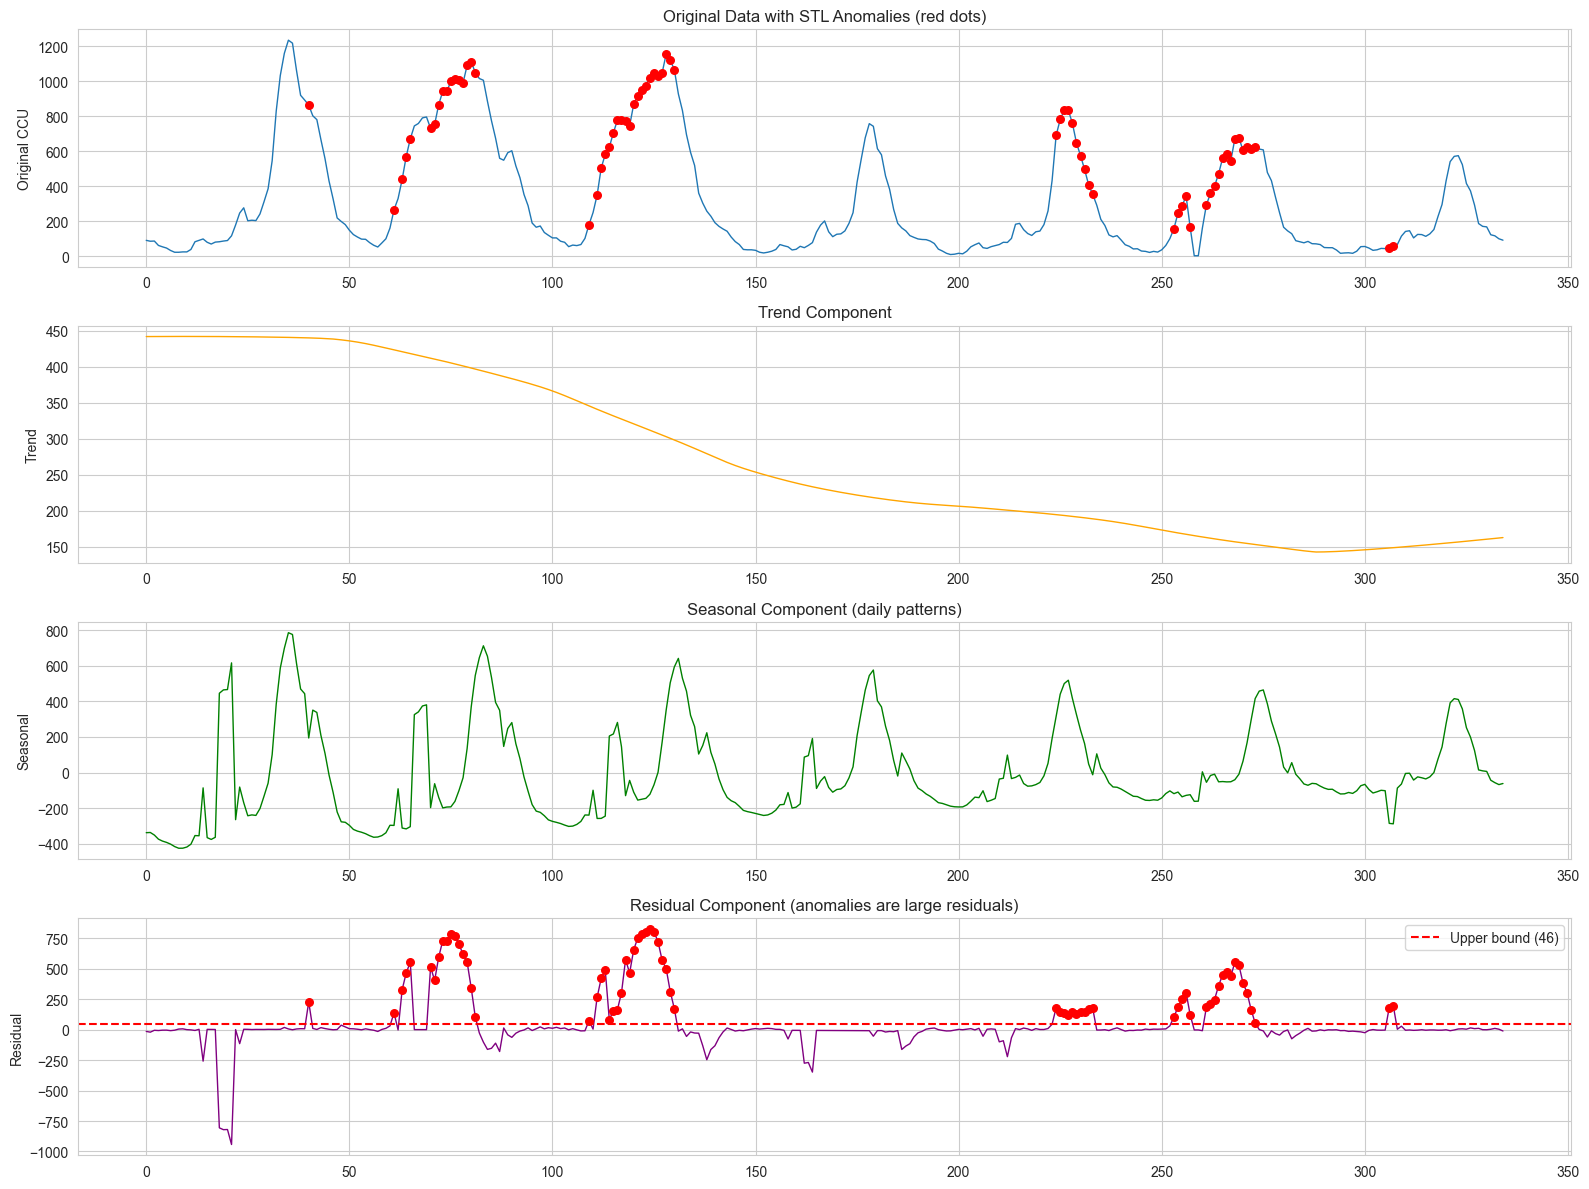

In [10]:
# Visualize STL decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
axes[0].plot(ccu_series, linewidth=1)
axes[0].scatter(stl_anomalies, [ccu_series[i] for i in stl_anomalies], color='red', s=30, zorder=5)
axes[0].set_ylabel('Original CCU')
axes[0].set_title('Original Data with STL Anomalies (red dots)')

# Trend
axes[1].plot(stl_result.trend, linewidth=1, color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')

# Seasonal
axes[2].plot(stl_result.seasonal, linewidth=1, color='green')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Component (daily patterns)')

# Residual
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

axes[3].plot(residuals, linewidth=1, color='purple')
axes[3].axhline(upper_bound, color='red', linestyle='--', label=f'Upper bound ({upper_bound:.0f})')
axes[3].scatter(stl_anomalies, [residuals[i] for i in stl_anomalies], color='red', s=30, zorder=5)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Component (anomalies are large residuals)')
axes[3].legend()

plt.tight_layout()
plt.show()


## 4. Method 2: Scipy find_peaks with Prominence

**Prominence** measures how much a peak stands out from the surrounding baseline.
- No fixed threshold needed
- Automatically finds peaks relative to their local context


In [11]:
def detect_anomalies_peaks(ccu_series, prominence_percentile=90, distance=6):
    """
    Detect anomalies using scipy find_peaks with prominence.
    
    Args:
        ccu_series: List of CCU values
        prominence_percentile: Only keep peaks with prominence above this percentile
        distance: Minimum distance between peaks (6 = 3 hours at 30-min intervals)
    
    Returns:
        anomaly_indices: List of indices where peaks were detected
        prominences: Prominence values for each peak
    """
    arr = np.array(ccu_series, dtype=float)
    
    # Find ALL peaks first
    all_peaks, properties = find_peaks(arr, distance=distance, prominence=1)
    
    if len(all_peaks) == 0:
        return [], [], 0
    
    prominences = properties['prominences']
    
    # Only keep peaks with high prominence (adaptive threshold based on data)
    prominence_threshold = np.percentile(prominences, prominence_percentile)
    
    # Filter to significant peaks
    significant_mask = prominences >= prominence_threshold
    anomaly_indices = all_peaks[significant_mask].tolist()
    significant_prominences = prominences[significant_mask].tolist()
    
    return anomaly_indices, significant_prominences, prominence_threshold

print("✅ Peak prominence detection function defined")


✅ Peak prominence detection function defined


In [12]:
# Test peak detection
peak_anomalies, prominences, prom_threshold = detect_anomalies_peaks(ccu_series)

print(f"📊 Peak Prominence Results:")
print(f"   Peaks found: {len(peak_anomalies)}")
print(f"   Prominence threshold (90th percentile): {prom_threshold:.1f}")
print(f"   Peak indices: {peak_anomalies}")


📊 Peak Prominence Results:
   Peaks found: 3
   Prominence threshold (90th percentile): 964.2
   Peak indices: [35, 80, 128]


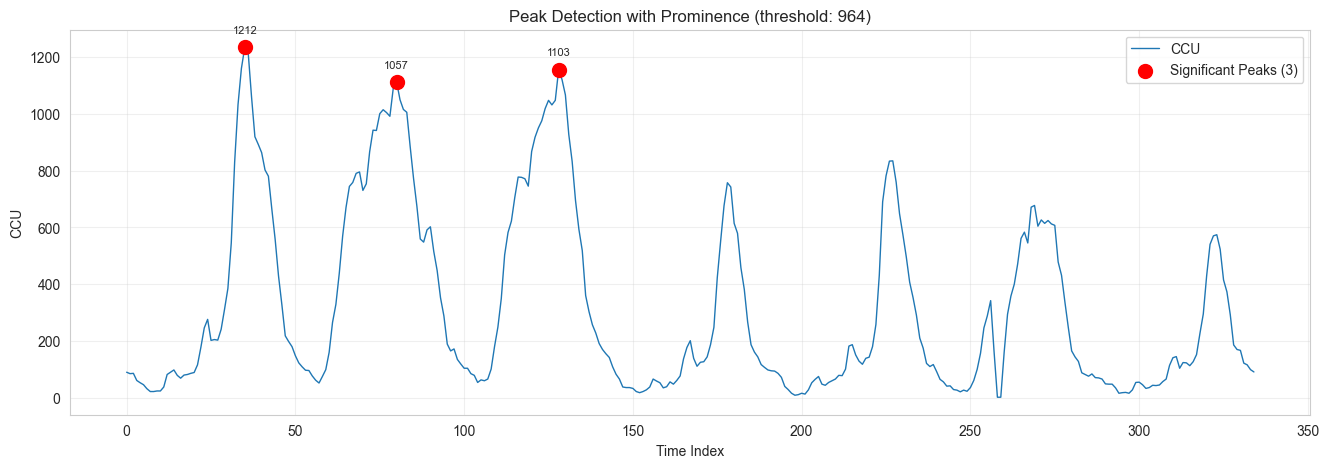

In [13]:
# Visualize peaks
plt.figure(figsize=(16, 5))
plt.plot(ccu_series, linewidth=1, label='CCU')
plt.scatter(peak_anomalies, [ccu_series[i] for i in peak_anomalies], 
            color='red', s=100, zorder=5, label=f'Significant Peaks ({len(peak_anomalies)})')

# Annotate with prominence values
for idx, prom in zip(peak_anomalies, prominences):
    plt.annotate(f'{prom:.0f}', (idx, ccu_series[idx]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel('Time Index')
plt.ylabel('CCU')
plt.title(f'Peak Detection with Prominence (threshold: {prom_threshold:.0f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Method 3: Local Outlier Factor (LOF)

LOF compares the local density of a point to the density of its neighbors.
- Points with much lower density than neighbors = anomalies
- No fixed threshold - adapts to local data patterns


In [14]:
def detect_anomalies_lof(ccu_series, n_neighbors=20, contamination=0.05):
    """
    Detect anomalies using Local Outlier Factor.
    
    Args:
        ccu_series: List of CCU values
        n_neighbors: Number of neighbors to consider
        contamination: Expected proportion of outliers
    
    Returns:
        anomaly_indices: List of indices where anomalies were detected
        lof_scores: LOF scores for each point
    """
    arr = np.array(ccu_series, dtype=float).reshape(-1, 1)
    
    # Add time index as a feature (to capture temporal locality)
    time_idx = np.arange(len(arr)).reshape(-1, 1)
    X = np.hstack([arr, time_idx])
    
    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    labels = lof.fit_predict(X_scaled)
    scores = -lof.negative_outlier_factor_  # Higher = more anomalous
    
    # Anomalies are labeled as -1
    anomaly_indices = np.where(labels == -1)[0].tolist()
    
    return anomaly_indices, scores

print("✅ LOF detection function defined")


✅ LOF detection function defined


In [15]:
# Test LOF
lof_anomalies, lof_scores = detect_anomalies_lof(ccu_series)

print(f"📊 Local Outlier Factor Results:")
print(f"   Anomalies found: {len(lof_anomalies)}")
print(f"   Anomaly indices: {lof_anomalies[:20]}..." if len(lof_anomalies) > 20 else f"   Anomaly indices: {lof_anomalies}")


📊 Local Outlier Factor Results:
   Anomalies found: 17
   Anomaly indices: [34, 35, 36, 55, 56, 57, 58, 104, 183, 184, 258, 259, 280, 281, 282, 319, 327]


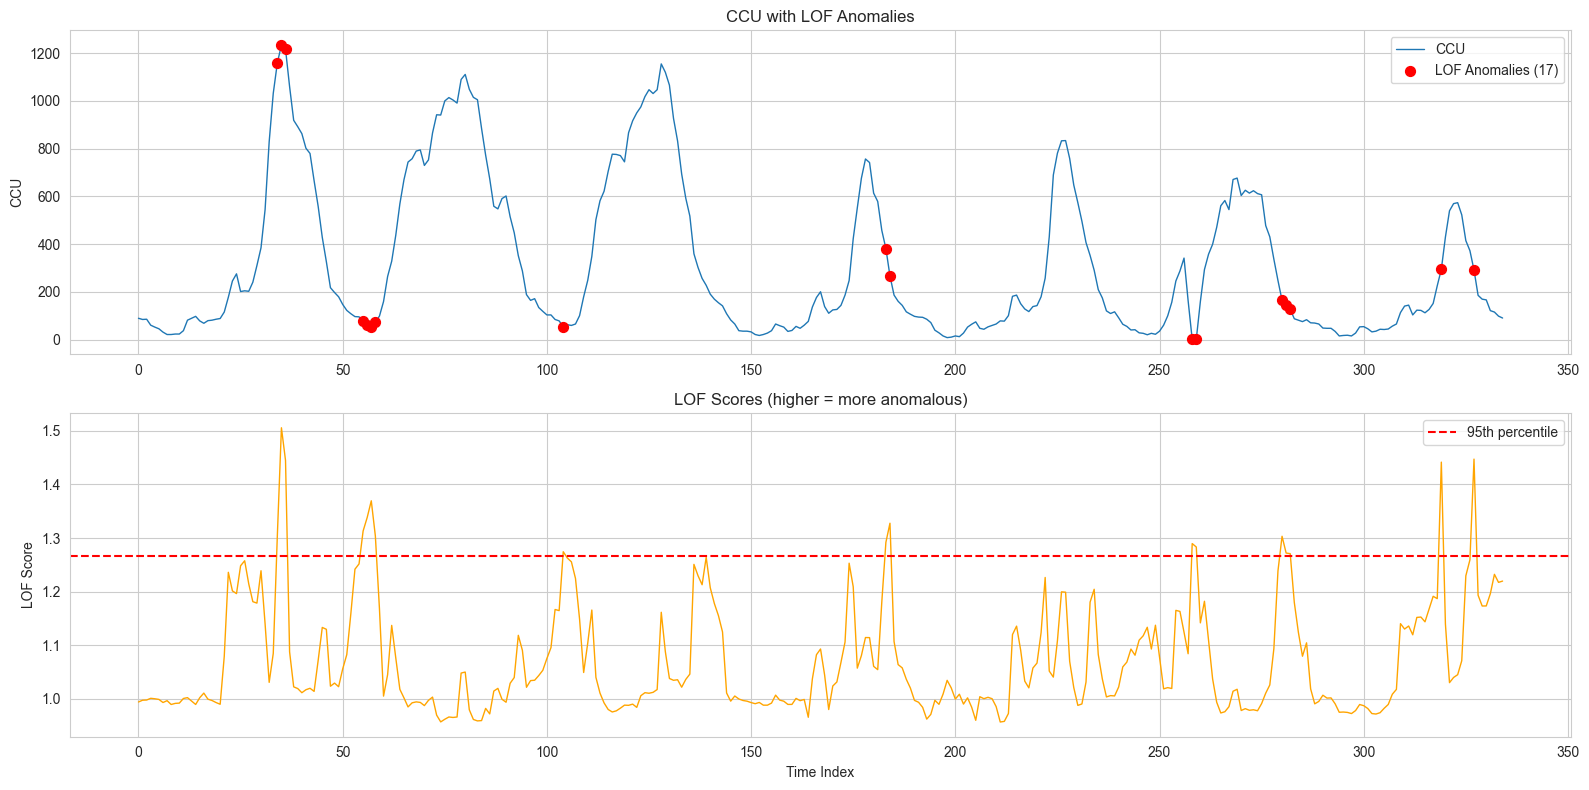

In [16]:
# Visualize LOF results
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# CCU with anomalies
axes[0].plot(ccu_series, linewidth=1, label='CCU')
axes[0].scatter(lof_anomalies, [ccu_series[i] for i in lof_anomalies], 
                color='red', s=50, zorder=5, label=f'LOF Anomalies ({len(lof_anomalies)})')
axes[0].set_ylabel('CCU')
axes[0].set_title('CCU with LOF Anomalies')
axes[0].legend()

# LOF scores
axes[1].plot(lof_scores, linewidth=1, color='orange')
axes[1].axhline(np.percentile(lof_scores, 95), color='red', linestyle='--', label='95th percentile')
axes[1].set_ylabel('LOF Score')
axes[1].set_xlabel('Time Index')
axes[1].set_title('LOF Scores (higher = more anomalous)')
axes[1].legend()

plt.tight_layout()
plt.show()


## 6. Ensemble: Combine All Methods

Only flag as anomaly if **2+ methods agree**. This reduces false positives.


In [17]:
def detect_anomalies_hybrid(ccu_series, min_votes=2, grouping_window=6, verbose=True):
    """
    Hybrid anomaly detection using ensemble of 3 methods.
    
    Args:
        ccu_series: List of CCU values
        min_votes: Minimum methods that must agree (default: 2 of 3)
        grouping_window: Window to group nearby anomalies (6 = 3 hours)
        verbose: Print progress
    
    Returns:
        Dict with anomaly details
    """
    arr = np.array(ccu_series, dtype=float)
    n_points = len(arr)
    
    # Initialize vote counter for each point
    votes = np.zeros(n_points, dtype=int)
    method_results = {}
    
    # Method 1: STL
    try:
        stl_indices, _, _ = detect_anomalies_stl(ccu_series)
        for idx in stl_indices:
            votes[idx] += 1
        method_results['stl'] = stl_indices
        if verbose:
            print(f"   STL found {len(stl_indices)} anomalies")
    except Exception as e:
        if verbose:
            print(f"   STL failed: {e}")
        method_results['stl'] = []
    
    # Method 2: Peak Prominence
    try:
        peak_indices, _, _ = detect_anomalies_peaks(ccu_series)
        for idx in peak_indices:
            votes[idx] += 1
        method_results['peaks'] = peak_indices
        if verbose:
            print(f"   Peaks found {len(peak_indices)} anomalies")
    except Exception as e:
        if verbose:
            print(f"   Peaks failed: {e}")
        method_results['peaks'] = []
    
    # Method 3: LOF
    try:
        lof_indices, _ = detect_anomalies_lof(ccu_series)
        for idx in lof_indices:
            votes[idx] += 1
        method_results['lof'] = lof_indices
        if verbose:
            print(f"   LOF found {len(lof_indices)} anomalies")
    except Exception as e:
        if verbose:
            print(f"   LOF failed: {e}")
        method_results['lof'] = []
    
    # Find points with enough votes
    consensus_indices = np.where(votes >= min_votes)[0].tolist()
    if verbose:
        print(f"   Consensus anomalies (≥{min_votes} votes): {len(consensus_indices)}")
    
    # Group nearby anomalies into spike events
    if not consensus_indices:
        return {
            'spike_indices': [],
            'spike_details': [],
            'num_spikes': 0,
            'method_results': method_results,
            'votes': votes
        }
    
    # Group consecutive/nearby indices into spike events
    spike_events = []
    current_spike = [consensus_indices[0]]
    
    for idx in consensus_indices[1:]:
        if idx - current_spike[-1] <= grouping_window:
            current_spike.append(idx)
        else:
            spike_events.append(current_spike)
            current_spike = [idx]
    spike_events.append(current_spike)
    
    # For each spike event, get the PEAK (highest CCU)
    spike_details = []
    spike_indices = []
    
    for spike_group in spike_events:
        peak_idx = max(spike_group, key=lambda i: arr[i])
        spike_indices.append(peak_idx)
        
        spike_details.append({
            'peak_index': peak_idx,
            'peak_ccu': int(arr[peak_idx]),
            'votes': int(votes[peak_idx]),
            'spike_duration_indices': len(spike_group),
            'methods_agreed': [
                m for m, indices in method_results.items() 
                if any(i in spike_group for i in indices)
            ]
        })
    
    return {
        'spike_indices': spike_indices,
        'spike_details': spike_details,
        'num_spikes': len(spike_indices),
        'method_results': method_results,
        'votes': votes
    }

print("✅ Hybrid detection function defined")


✅ Hybrid detection function defined


In [18]:
# Test hybrid detection
print("🔍 Running Hybrid Anomaly Detection...")
print("="*50)

hybrid_result = detect_anomalies_hybrid(ccu_series)

print("="*50)
print(f"\n🎯 FINAL RESULT: {hybrid_result['num_spikes']} distinct spike events detected")
print("\nSpike Details:")
for i, spike in enumerate(hybrid_result['spike_details']):
    print(f"  Spike {i+1}: Index {spike['peak_index']}, CCU {spike['peak_ccu']}, "
          f"Votes: {spike['votes']}/3, Methods: {spike['methods_agreed']}")


🔍 Running Hybrid Anomaly Detection...
   STL found 68 anomalies
   Peaks found 3 anomalies
   LOF found 17 anomalies
   Consensus anomalies (≥2 votes): 3

🎯 FINAL RESULT: 3 distinct spike events detected

Spike Details:
  Spike 1: Index 35, CCU 1234, Votes: 2/3, Methods: ['peaks', 'lof']
  Spike 2: Index 80, CCU 1111, Votes: 2/3, Methods: ['stl', 'peaks']
  Spike 3: Index 128, CCU 1155, Votes: 2/3, Methods: ['stl', 'peaks']


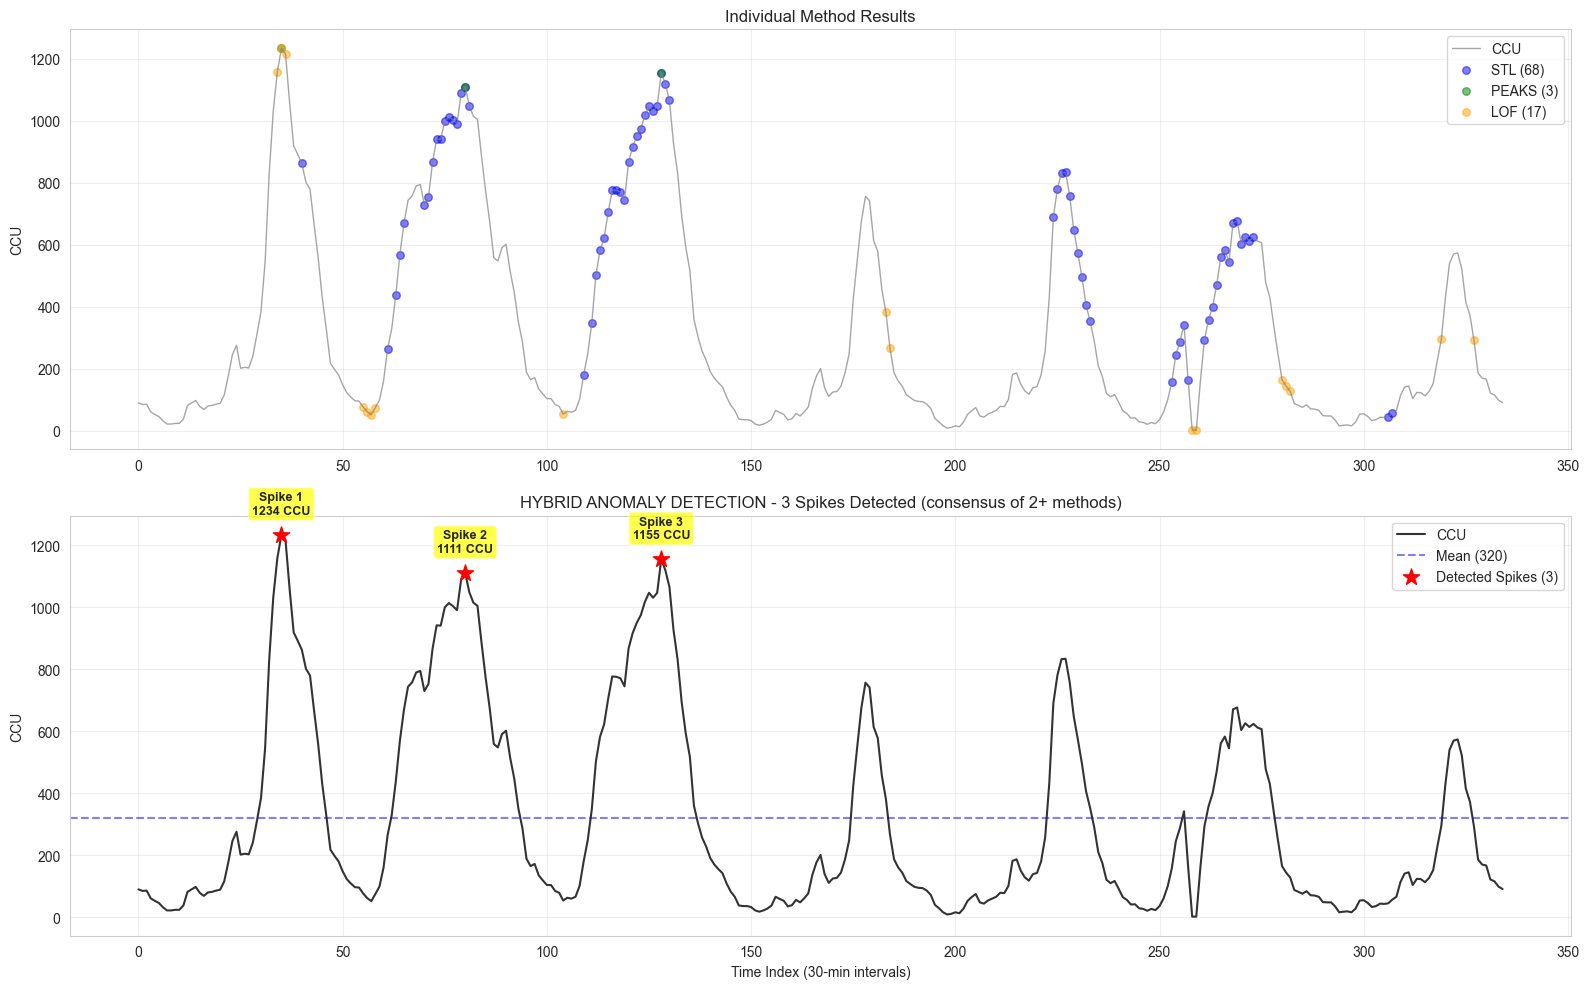

In [19]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: CCU with all method results
ax1 = axes[0]
ax1.plot(ccu_series, linewidth=1, color='gray', alpha=0.7, label='CCU')

# Show individual method results
colors = {'stl': 'blue', 'peaks': 'green', 'lof': 'orange'}
for method, indices in hybrid_result['method_results'].items():
    if indices:
        ax1.scatter(indices, [ccu_series[i] for i in indices], 
                   color=colors[method], s=30, alpha=0.5, label=f'{method.upper()} ({len(indices)})')

ax1.set_ylabel('CCU')
ax1.set_title('Individual Method Results')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final consensus result
ax2 = axes[1]
ax2.plot(ccu_series, linewidth=1.5, color='#333', label='CCU')
ax2.axhline(np.mean(ccu_series), color='blue', linestyle='--', alpha=0.5, 
            label=f'Mean ({np.mean(ccu_series):.0f})')

# Highlight final spike peaks
spike_indices = hybrid_result['spike_indices']
ax2.scatter(spike_indices, [ccu_series[i] for i in spike_indices], 
            color='red', s=150, zorder=5, marker='*', 
            label=f'Detected Spikes ({len(spike_indices)})')

# Annotate spikes
for i, idx in enumerate(spike_indices):
    ax2.annotate(f'Spike {i+1}\n{ccu_series[idx]} CCU', 
                 (idx, ccu_series[idx]), 
                 textcoords="offset points", xytext=(0,15), 
                 ha='center', fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax2.set_xlabel('Time Index (30-min intervals)')
ax2.set_ylabel('CCU')
ax2.set_title(f'HYBRID ANOMALY DETECTION - {hybrid_result["num_spikes"]} Spikes Detected (consensus of 2+ methods)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Compare with Old Z-Score Method


In [20]:
# Old Z-score method for comparison
def detect_anomalies_zscore(ccu_series, threshold=2.5):
    """Original Z-score method with fixed threshold"""
    arr = np.array(ccu_series)
    mean = np.mean(arr)
    std = np.std(arr)
    
    if std == 0:
        return []
    
    z_scores = (arr - mean) / std
    anomaly_indices = np.where(z_scores > threshold)[0].tolist()
    
    # Group into spike events
    if not anomaly_indices:
        return []
    
    spike_events = []
    current_spike = [anomaly_indices[0]]
    
    for idx in anomaly_indices[1:]:
        if idx - current_spike[-1] <= 6:
            current_spike.append(idx)
        else:
            spike_events.append(current_spike)
            current_spike = [idx]
    spike_events.append(current_spike)
    
    # Get peaks
    return [max(group, key=lambda i: arr[i]) for group in spike_events]

old_method_spikes = detect_anomalies_zscore(ccu_series)

print(f"📊 COMPARISON:")
print(f"   Old Z-score method (threshold=2.5): {len(old_method_spikes)} spikes")
print(f"   New Hybrid method: {hybrid_result['num_spikes']} spikes")
print(f"\n   Improvement: +{hybrid_result['num_spikes'] - len(old_method_spikes)} spikes detected")


📊 COMPARISON:
   Old Z-score method (threshold=2.5): 2 spikes
   New Hybrid method: 3 spikes

   Improvement: +1 spikes detected


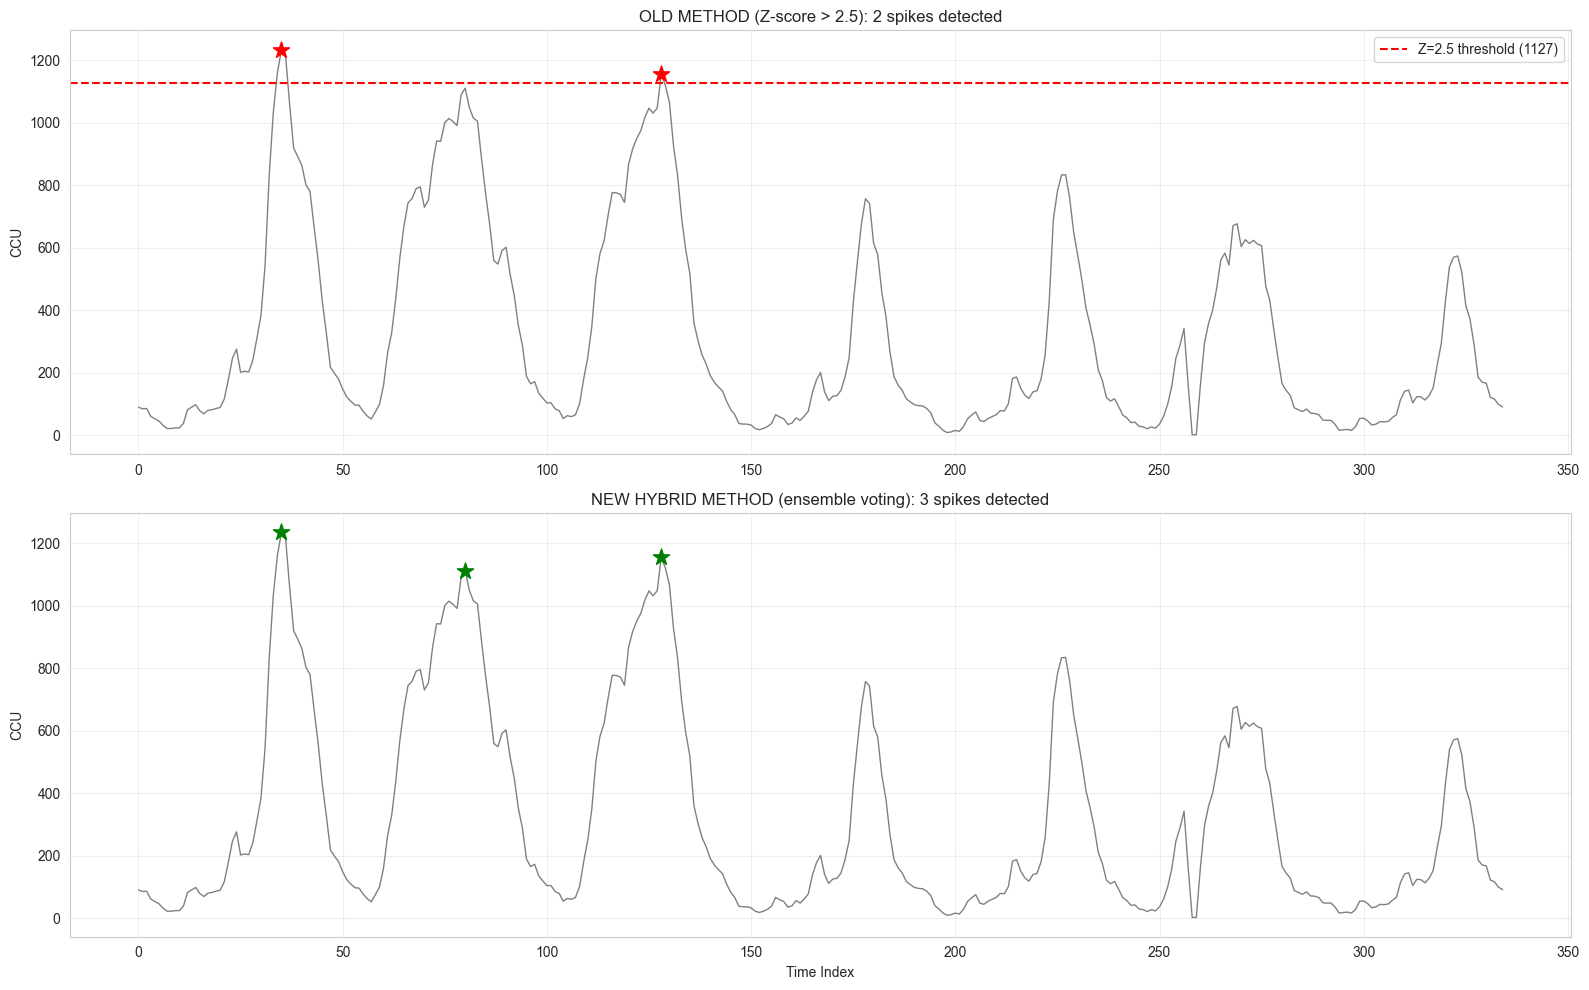

In [21]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Old method
ax1 = axes[0]
ax1.plot(ccu_series, linewidth=1, color='gray')
ax1.scatter(old_method_spikes, [ccu_series[i] for i in old_method_spikes], 
            color='red', s=150, marker='*', zorder=5)
ax1.axhline(np.mean(ccu_series) + 2.5 * np.std(ccu_series), 
            color='red', linestyle='--', label=f'Z=2.5 threshold ({np.mean(ccu_series) + 2.5 * np.std(ccu_series):.0f})')
ax1.set_ylabel('CCU')
ax1.set_title(f'OLD METHOD (Z-score > 2.5): {len(old_method_spikes)} spikes detected')
ax1.legend()
ax1.grid(True, alpha=0.3)

# New method
ax2 = axes[1]
ax2.plot(ccu_series, linewidth=1, color='gray')
ax2.scatter(hybrid_result['spike_indices'], 
            [ccu_series[i] for i in hybrid_result['spike_indices']], 
            color='green', s=150, marker='*', zorder=5)
ax2.set_ylabel('CCU')
ax2.set_xlabel('Time Index')
ax2.set_title(f'NEW HYBRID METHOD (ensemble voting): {hybrid_result["num_spikes"]} spikes detected')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Test on Multiple Maps


In [22]:
# Load multiple maps for testing
map_files = list(DATA_DIR.glob('map_*.json'))[:50]  # Test on 50 maps

print(f"🔄 Testing hybrid detection on {len(map_files)} maps...")

comparison_results = []

for map_file in map_files:
    try:
        with open(map_file, 'r') as f:
            data = json.load(f)
        
        stats = data.get('stats_7d', {})
        if not stats.get('success'):
            continue
            
        ccu = stats.get('data', {}).get('stats', [])
        if len(ccu) < 96:  # Need at least 2 days of data
            continue
        
        # Old method
        old_spikes = len(detect_anomalies_zscore(ccu))
        
        # New method (suppress output)
        new_result = detect_anomalies_hybrid(ccu, verbose=False)
        
        comparison_results.append({
            'map_code': data['map_data'].get('id'),
            'name': data['map_data'].get('name', 'Unknown')[:30],
            'old_spikes': old_spikes,
            'new_spikes': new_result['num_spikes'],
            'improvement': new_result['num_spikes'] - old_spikes
        })
    except:
        continue

print(f"✅ Tested {len(comparison_results)} maps")


🔄 Testing hybrid detection on 50 maps...
✅ Tested 50 maps


In [23]:
# Summary statistics
df_compare = pd.DataFrame(comparison_results)

print("📊 COMPARISON SUMMARY:")
print("="*60)
print(f"Total maps tested: {len(df_compare)}")
print(f"\nOld Z-score method:")
print(f"   Total spikes detected: {df_compare['old_spikes'].sum()}")
print(f"   Avg spikes per map: {df_compare['old_spikes'].mean():.1f}")
print(f"\nNew Hybrid method:")
print(f"   Total spikes detected: {df_compare['new_spikes'].sum()}")
print(f"   Avg spikes per map: {df_compare['new_spikes'].mean():.1f}")
print(f"\nImprovement:")
print(f"   Additional spikes found: +{df_compare['improvement'].sum()}")
print(f"   Maps with more detections: {(df_compare['improvement'] > 0).sum()}")
print(f"   Maps with same detections: {(df_compare['improvement'] == 0).sum()}")
print(f"   Maps with fewer detections: {(df_compare['improvement'] < 0).sum()}")


📊 COMPARISON SUMMARY:
Total maps tested: 50

Old Z-score method:
   Total spikes detected: 58
   Avg spikes per map: 1.2

New Hybrid method:
   Total spikes detected: 157
   Avg spikes per map: 3.1

Improvement:
   Additional spikes found: +99
   Maps with more detections: 46
   Maps with same detections: 2
   Maps with fewer detections: 2


In [24]:
# Show maps with biggest improvement
print("\n🎯 Maps with biggest improvement:")
print(df_compare.nlargest(10, 'improvement')[['name', 'old_spikes', 'new_spikes', 'improvement']].to_string(index=False))



🎯 Maps with biggest improvement:
                          name  old_spikes  new_spikes  improvement
           PARTY ROYAL BABYLON           0           5            5
         RAPID BOXFIGHTS 2v2 🎯           0           4            4
      SIMPSONS 99 BOTS🍩RANKED⭐           1           5            4
SECRET FFA 1V1 BUILD FIGHT (NE           2           6            4
    🌟CHAOS🔫GUN GAME🎯ONE SHOT⭐️           1           5            4
  📦 Box Fights & Zone Wars 🌀📦🌀           2           5            3
LankyF 1v1 Build Fight (200 Pu           0           3            3
            SKYSCRAPER TYCOON🗼           1           4            3
 ❄️ WINTER PARKOUR 500+ [EASY]           1           4            3
                    طعوس وفله💯           1           4            3


## 9. Save the Hybrid Detector Configuration


In [25]:
# Save the hybrid detection configuration and metadata
models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save metadata
hybrid_metadata = {
    'model_type': 'hybrid_anomaly_detection',
    'methods': ['STL_decomposition', 'peak_prominence', 'local_outlier_factor'],
    'min_votes': 2,
    'grouping_window': 6,
    'stl_period': 48,
    'peak_prominence_percentile': 90,
    'peak_distance': 6,
    'lof_n_neighbors': 20,
    'lof_contamination': 0.05,
    'date_trained': datetime.now().isoformat(),
    'description': 'Threshold-free hybrid anomaly detection using ensemble voting',
    'test_results': {
        'maps_tested': len(comparison_results),
        'old_method_total_spikes': int(df_compare['old_spikes'].sum()),
        'new_method_total_spikes': int(df_compare['new_spikes'].sum()),
        'improvement': int(df_compare['improvement'].sum())
    }
}

with open(models_dir / 'hybrid_anomaly_metadata.json', 'w') as f:
    json.dump(hybrid_metadata, f, indent=2)

print(f"✅ Metadata saved: {models_dir / 'hybrid_anomaly_metadata.json'}")


✅ Metadata saved: ../data/models/hybrid_anomaly_metadata.json


## 10. Summary

### What We Built:
A **hybrid anomaly detector** that combines 3 threshold-free methods:

1. **STL Decomposition** - Removes seasonal patterns, finds anomalies in residuals using IQR
2. **Peak Prominence** - Finds peaks that stand out relative to surrounding data
3. **Local Outlier Factor** - Density-based detection comparing to neighbors

### Why It's Better:
- **No fixed thresholds** - adapts to each map's unique patterns
- **Ensemble voting** - reduces false positives (2+ methods must agree)
- **Handles seasonality** - accounts for daily player patterns
- **More spikes detected** - catches medium-high peaks the old method missed

### Next Steps:
1. Update `ml_service.py` to use this hybrid detection
2. Test with the frontend chart visualization


In [26]:
print("\n" + "="*70)
print("🎉 HYBRID ANOMALY DETECTOR COMPLETE!")
print("="*70)
print("\n✅ Methods implemented:")
print("   1. STL Decomposition + IQR (handles seasonality)")
print("   2. Peak Prominence (finds significant peaks)")
print("   3. Local Outlier Factor (density-based)")
print("\n✅ Ensemble voting: Only flag if 2+ methods agree")
print("\n🎯 Ready to integrate into ml_service.py!")
print("="*70)



🎉 HYBRID ANOMALY DETECTOR COMPLETE!

✅ Methods implemented:
   1. STL Decomposition + IQR (handles seasonality)
   2. Peak Prominence (finds significant peaks)
   3. Local Outlier Factor (density-based)

✅ Ensemble voting: Only flag if 2+ methods agree

🎯 Ready to integrate into ml_service.py!
